### Изучение поведения пользователей мобильного приложения
_____
##### Описание данных

Путь к файлу: [Скачать датасет](https://code.s3.yandex.net/datasets/logs_exp.csv)

Структура `/datasets/logs_exp.csv`:

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
______

###### Данное исследование разделим на несколько частей.

##### Часть 1. Изучение общей информации:
1. Изучение файла с данными, получение общей информации, загрузка библиотек;

##### Часть 2. Подготовка данных:
1. Замена названия столбцов;
2. Приведение данных к нужным типам;
3. Нахождение и исправление пропусков, аномалий и ошибок;
4. Добавление столбца даты и времени, а также отдельного столбца дат.

##### Часть 3. Изучение и проверка данных:

1. Подсчет событий в логе;
2. Подсчет общего кол-ва пользователей в логе;
3. Подсчет количества в событий, приходящихся на пользователя в среднем;
4. Определения периода, за который представлены данные. Поиск максимальной и минимальной даты. Построение гистограммы по дате и времени. Определение, с какого момента данные полные и отбрасывание более старых. Определение за какой период данные представлены на самом деле;
5. Подсчет количества событий, которые были потеряны после отброса данных;
6. Проверка наличия пользователей из всех трёх экспериментальных групп.

##### Часть 4. Изучение воронки событий:

1. Проверка, какие события есть в логах, как часто они встречаются. Сортировка событий по частоте;
2. Подсчет пользователей, совершивших каждое из этих событий. Сортировка событий по числу пользователей. Подсчет доли пользователей, которые хоть раз совершали событие;
3. Предположение, в каком порядке происходят события;
4. Подсчет по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем);
5. Определение, на каком шаге теряется больше всего пользователей;
6. Определение, какая доля пользователей доходит от первого события до оплаты.

##### Часть 4. Изучение результатов эксперимента:

1. Подсчет пользователей в каждой экспериментальной группе;
2. Проведение А/А теста по всем событиям;
3. А/В тест для контрольной группы 246 и группы с измененным шрифтом 248 по всем событиям.
5. А/В тест для контрольной группы 247 и группы с измененным шрифтом 248 по всем событиям.
6. А/В тест для контрольной группы 246 + 247 и группы с измененным шрифтом 248 по всем событиям.
7. Обоснование выбора уровня значимости при проверке статистических гипотез выше.

##### Часть 5. Выводы

## Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth

from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    data_first = pd.read_csv('/datasets/logs_exp.csv', sep="\t")
except:
    data_first = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
# зададим функцию для первичного изучения данных 
def first_data_check(data):
    return display(data.head(20)), display(data.info()), print('Количество пропусков:'), display(data.isna().sum()), print('Количество дубликатов:', (data.duplicated().sum()))

In [4]:
first_data_check(data_first);

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество пропусков:


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Количество дубликатов: 413


## Подготовка данных

In [5]:
data_first.columns=['event_name', 'user_id', 'event_time', 'group'] # замена названия столбцов               
data_first.columns #проверка

Index(['event_name', 'user_id', 'event_time', 'group'], dtype='object')

Типы данных в порядке. При первичной проверке данных были выявленs 413 явных дубликатов. Удалим их.

In [6]:
data1 = data_first.drop_duplicates().reset_index(drop=True)
data1.duplicated().sum() #проверка

0

In [7]:
print('Было строк -', len(data_first), ", удалили дубликатов - ", (data_first.duplicated().sum()), 
      ", осталось строк -", (len(data_first) - (data_first.duplicated().sum())), 
      '\nСократили', round(100 - (((len(data_first) - (data_first.duplicated().sum())) / len(data_first) * 100)), 2), '% данных')

Было строк - 244126 , удалили дубликатов -  413 , осталось строк - 243713 
Сократили 0.17 % данных


In [8]:
# узнаем, сколько групп в А/В тесте

print('Группы А/A/B теста в таблице:', data1['group'].unique())

Группы А/A/B теста в таблице: [246 248 247]


In [9]:
# изменим названия групп для удобства

data1['group'].replace(to_replace= (246,247,248), value = ('A1', 'A2', 'B'), inplace=True ) 

In [10]:
# проверим, сколько пользователей в каждой группе

data1.pivot_table(index='group', values='user_id', aggfunc='nunique')

,user_id
group,
A1,2489
A2,2520
B,2542


Мы видим, что количество пользователей группы А1 больше, чем количество пользователей группы А2 на 1.25%, количество пользователей группы В больше кол-ва пользователей группы А1 на 2.08% и группы А2 на 0.87%. Разница между А1 и А2, а также между В и А1 больше, чем 1%. Если бы это был не учебный проект, данная информация была бы передана до группы, занимающейся сбором данных.

In [11]:
# добавим столбец даты и времени, а также отдельный столбец дат

data1['date_time'] = pd.to_datetime(data1['event_time'], unit='s')
data1['date'] = data1['date_time'].dt.floor('1D')

display(data1.head()) # проверка
data1.info()

,event_name,user_id,event_time,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  int64         
 3   group       243713 non-null  object        
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


Вывод: данные прошли первичную проверку и готовы для дальнейшего анализа

- Изменены названия столбцов
- Удалены явные дубликаты (0.17% данных)
- Добавлены столбцы с датой и временем
- Изменены названия групп на А1/А2/В
- Провели проверку количества пользователей в каждой группе

## Изучение и проверка данных

In [12]:
# Подсчет собыйтий в логе

print('Всего событий в логе:', len(data1))

Всего событий в логе: 243713


In [13]:
# Подсчет пользователей в логе

print('Всего пользователей в логе:', data1['user_id'].nunique())

Всего пользователей в логе: 7551


In [14]:
# Подсчет количества событий, приходящихся на пользователя в среднем

event_per_user = data1.groupby('user_id')['event_name'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

В среднем на пользователя приходится 32 события. 

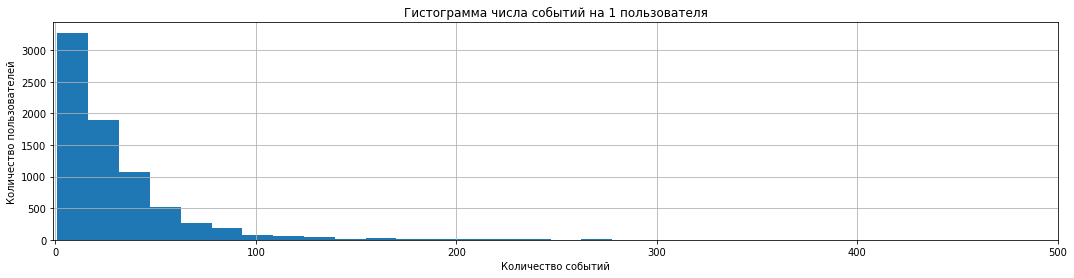

In [15]:
# построим гистограмму числа событий на 1 пользователя

plt.figure(figsize=(18,4))
event_per_user.hist(bins=150)
plt.xlim([-1, 500])
plt.title('Гистограмма числа событий на 1 пользователя')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество событий');

In [16]:
# узнаем, за какой период представлены данные в таблицах

print('Период данных:', data1['date_time'].min(), '-', data1['date_time'].max())

Период данных: 2019-07-25 04:43:36 - 2019-08-07 21:15:17


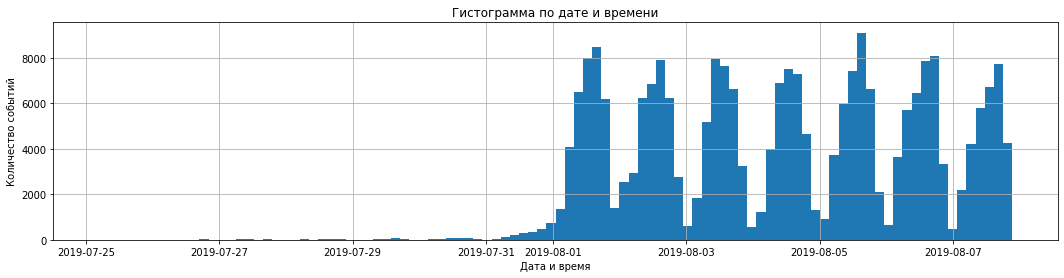

In [17]:
# построим гистограмму по дате и времени

plt.figure(figsize=(18,4))
data1['date_time'].hist(bins=100)
plt.title('Гистограмма по дате и времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата и время');

По графику видно, что события представлены с 01.08.2019 года, а до этой даты событий было мало. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Отбросим старые данные.

In [18]:
data = data1.query('date >= "2019-08-01"')
print('Актуальный период данных:', data['date_time'].min(), '-', data['date_time'].max())

Актуальный период данных: 2019-08-01 00:07:28 - 2019-08-07 21:15:17


In [19]:
print('Было событий -', len(data1), ", осталось событий -", len(data),
      '\nСократили', round(100 - (len(data)/len(data1) * 100), 2), '% данных')

print('Было пользователей - ', data1['user_id'].nunique(), 
      ", осталось пользователей -", data['user_id'].nunique(),
      '\nСократили', round(100 - ( data['user_id'].nunique() / data1['user_id'].nunique() * 100), 2), '% данных')

Было событий - 243713 , осталось событий - 240887 
Сократили 1.16 % данных
Было пользователей -  7551 , осталось пользователей - 7534 
Сократили 0.23 % данных


In [20]:
# убедимся, что у нас есть пользователи в каждой из трех групп

data.pivot_table(index='group', values='user_id', aggfunc='nunique')

,user_id
group,
A1,2484
A2,2513
B,2537


Вывод: данные были изучены и проверены для дальнейшего анализа

- Количество событий - 240 887 , количество пользователей - 7 534
- Определен актуальный период, за который представлены данные - с 01.08.2019 по 07.08.2019
- Сократили неактуальные данные за прошлые периоды - 1.16% событий и 0.23% пользователей
- Убедились, что пользователи представлены в каждой группе, в группе А1 - 2 485, в группе А2 - 2 513, в группе В - 2 537

## Изучение воронки событий

In [21]:
# посмотрим, какие события есть в логах, как часто они встречаются, отсортируем события по частоте

data.pivot_table(index='event_name', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В датафрейме представлено 5 типов событий (переход на страницу с корзиной, переход на главную страницу, переход на страницу с предложениями, переход на страницу с успешной оплатой, переход на страницу с обучением). Пользователи чаще всего переходят на главную страницу, меньше всего заглядывают на страницу с обучением.

In [22]:
# Посчитаем, сколько пользователей совершали каждое из этих событий. 
# Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

events = data.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events.columns=['amount', 'user_id'] # замена названия столбцов               
events['proportion_%'] = (events['user_id'] / data['user_id'].nunique() * 100).round(2)
events = events.reset_index()
events

,event_name,amount,user_id,proportion_%
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


98 % пользователей переходили на главный экран, 61% - на страницу с предложениями, почти одинаковые результаты для страниц с корзиной и успешной оплатой - 49% и 47%, и самая малая доля у страницы с обучением - 11 %.

Предположим порядок событий:

1) Просмотрел главную страницу;  
2) Перешел на странцу с предложениями;  
3) Перешел на страницу с корзиной;  
4) Перешел на страницу с успешной оплатой.

Переходов на страницу с обучением мало, и сложно предположить, в каком порядке может произойти это событие, не будем учитывать это событие при расчете воронки.

In [23]:
events = events.iloc[:-1, :] # удаляем событие с переходом на страницу обучения
events

,event_name,amount,user_id,proportion_%
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97


In [24]:
# По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки относительно предыдущего

events['funnel_share_%'] = (events['user_id'] / events['user_id'].shift()).round(3) * 100
events.iloc[0, -1] = (events.loc[0, 'user_id'] / data['user_id'].nunique()).round(3) * 100
events

,event_name,amount,user_id,proportion_%,funnel_share_%
0,MainScreenAppear,117328,7419,98.47,98.5
1,OffersScreenAppear,46333,4593,60.96,61.9
2,CartScreenAppear,42303,3734,49.56,81.3
3,PaymentScreenSuccessful,33918,3539,46.97,94.8


In [ ]:
# Построим воронку, какая доля пользователей проходит на следующий шаг воронки относительно предыдущего
fig = go.Figure(go.Funnel(x = events['funnel_share_%'], y = events['event_name']))
fig.update_layout(title='Доля пользователей, переходящих на следующий шаг воронки относительно предыдущего', title_x = 0.5)
fig.show();

По графику видно, что на шаге перехода от главной страницы к странице с предложениями теряется больше всего пользователей - 36,6%. 

In [ ]:
# Посмотрим, какая доля пользователей доходит от первого события до оплаты

events['funnel_share_from_first_%'] = (events['user_id'] / events.loc[0, 'user_id']).round(3) * 100
events

In [ ]:
# Построим воронку, какая доля пользователей проходит на следующий шаг воронки относительно первого события
fig = go.Figure(go.Funnel(x = events['funnel_share_from_first_%'], y = events['event_name']))
fig.update_layout(title='Доля пользователей, переходящих на следующий шаг воронки относительно первого события', title_x = 0.5)
fig.show();

По воронке можно увидеть, что от первого события до оплаты доходит 47,7% - хороший результат!

In [ ]:
# Построим воронки для каждой из групп по отдельности

data_A1 = data.query('group == "A1" & event_name != "Tutorial"')
events_A1 = data_A1.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_A1.columns=['amount', 'user_id'] # замена названия столбцов     
events_A1['proportion_%'] = (events_A1['user_id'] / data_A1['user_id'].nunique() * 100).round(2)
events_A1 = events_A1.reset_index()
events_A1['funnel_share_from_first_%'] = (events_A1['user_id'] / events_A1.loc[0, 'user_id']).round(3) * 100
display(events_A1)

data_A2 = data.query('group == "A2" & event_name != "Tutorial"')
events_A2 = data_A2.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_A2.columns=['amount', 'user_id'] # замена названия столбцов     
events_A2['proportion_%'] = (events_A2['user_id'] / data_A2['user_id'].nunique() * 100).round(2)
events_A2 = events_A2.reset_index()
events_A2['funnel_share_from_first_%'] = (events_A2['user_id'] / events_A2.loc[0, 'user_id']).round(3) * 100
display(events_A2)

data_B = data.query('group == "B" & event_name != "Tutorial"')
events_B = data_A1.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_B.columns=['amount', 'user_id'] # замена названия столбцов 
events_B['proportion_%'] = (events_B['user_id'] / data_B['user_id'].nunique() * 100).round(2)
events_B = events_B.reset_index()
events_B['funnel_share_from_first_%'] = (events_B['user_id'] / events_B.loc[0, 'user_id']).round(3) * 100
display(events_B)

In [ ]:
fig = go.Figure(go.Funnel(x = events_A1['funnel_share_from_first_%'], y = events_A1['event_name']))
fig.update_layout(title='Доля пользователей, переходящих на следующий шаг воронки относительно первого события, группа А1', title_x = 0.5)
fig.show();

fig = go.Figure(go.Funnel(x = events_A2['funnel_share_from_first_%'], y = events_A2['event_name']))
fig.update_layout(title='Доля пользователей, переходящих на следующий шаг воронки относительно первого события, группа А2', title_x = 0.5)
fig.show();

fig = go.Figure(go.Funnel(x = events_B['funnel_share_from_first_%'], y = events_B['event_name']))
fig.update_layout(title='Доля пользователей, переходящих на следующий шаг воронки относительно первого события, группа В', title_x = 0.5)
fig.show();

Мы видим, что конверсии в группах в по отедльности и общая конверсия распределены пропорционально, поэтому можем приступать к проведению тестов.

Вывод: были изучены воронки событий

- Предположили порядок событий:  
     1) Просмотрел главную страницу;  
     2) Перешел на странцу с предложениями;  
     3) Перешел на страницу с корзиной;  
     4) Перешел на страницу с успешной оплатой.  
- 98 % пользователей попадали на главный экран, 61% - на страницу с предложениями, почти одинаковые результаты для страниц с корзиной и успешной оплатой - 49% и 47%, и самая малая доля у страницы с обучением - 11 %.
- Переходов на страницу с обучением мало, и сложно предположить, в каком порядке может произойти это событие, это событие было исключено при расчете воронки
- На шаге перехода от главной страницы к странице с предложениями теряется больше всего пользователей - 36,6%, необходимо изучить, почему такое большое кол-во пользователей отсеивается на данном этапе
- От первого события (переход на главную страницу) до оплаты доходит 47,7% - хороший результат!

## Изучение результатов эксперимента

In [ ]:
#проверим, есть ли пользователи, попавшие в две или более группы

data.pivot_table(index='user_id', values='group', aggfunc='nunique').query('group > 1').count()

Пользователей, попавших в две или более группы, нет

Перед тем как начать A/B-тест, убедимся, что:
 - на результаты не влияют аномалии и выбросы в генеральной совокупности;
 - инструмент «деления» трафика работает безошибочно;
 - данные отправляются в системы аналитики корректно.
 
Для этого проведем А/А тест, в нашем случае проверим, находят ли статистические критерии разницу между группами А1 и А2

In [ ]:
# Посмотрим, сколько пользователей в каждой экспериментальной группе

group_users = data.pivot_table(index='group', values='user_id', aggfunc='nunique').reset_index()
group_users

В группе А1 - 2 484 пользователя, в группе А2 - 2 513 пользователя, в группе В - 2 537 пользователя. Количество пользователей в каждой группе соразмерно.

Сформулируем гипотезы:

- Н0 Нулевая: доли уникальных посетителей, побывавших на этапе воронки, не имеют статистически значимых различий
- Н1 Альтернативная: между долями уникальных посетителей, побывавших на этапе воронки, есть статистически значимые различия


Для проверки гипотез будем использовать Z-тест, так как этот метод определяет, являются ли два средних значения выборки примерно одинаковыми или разными. Размер выборки должен быть больше 30 - это правило соблюдено. Будем тестировать группы по всем событиям.

Уровень значимости alpha - 0.05

In [ ]:
# построим сводную таблицу для проверки гипотез

data_test = data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A1', ascending=False)
data_test = data_test.reset_index()
data_test['A1_and_A2'] = data_test['A1'] + data_test['A2']
data_test['all'] = data_test['A1_and_A2'] + data_test['B']
data_test['A1_all'] = group_users.loc[0, 'user_id']
data_test['A2_all'] = group_users.loc[1, 'user_id']
data_test['B_all'] = group_users.loc[2, 'user_id']
data_test['A1_and_A2_all'] = data_test['A1_all'] + data_test['A2_all']

data_test

In [ ]:
# зададим функцию для проведения теста

def proportion_test(successes, leads):
    # пропорция успехов в первой группе:
    p1 = successes[0]/leads[0]
# пропорция успехов во второй группе:
    p2 = successes[1]/leads[1]
# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (leads[0] + leads[1])
# разница пропорций в датасетах
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение по событию', data_test['event_name'][idx],':')
    print("{0:.5f}".format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
alpha = .05 # критический уровень статистической значимости

In [ ]:
# проведем А/А тест для каждого события

for idx, event in enumerate(data_test['event_name']):
    successes = np.array([data_test['A1'][idx], data_test['A2'][idx]])
    leads = np.array([data_test['A1_all'][idx], data_test['A2_all'][idx]])
    proportion_test(successes, leads)

По итогам теста, между контрольными группами для А/А теста - А1 и А2 - статистические критерии не находят разницу для всех событий. Мы можем сделать вывод, что разбиение на группы работает корректно.

Теперь проведем тест с группами А1 и В, А2 и В, А1+А2 и В. Сформулируем гипотезы:

- Н0 Нулевая: доли уникальных посетителей, побывавших на этапе воронки, не имеют статистически значимых различий
- Н1 Альтернативная: между долями уникальных посетителей, побывавших на этапе воронки, есть статистически значимые различия

Уровень значимости alpha - 0.05

In [ ]:
# проведем А/В тест с группами А1 и В

for idx, event in enumerate(data_test['event_name']):
    successes = np.array([data_test['A1'][idx], data_test['B'][idx]])
    leads = np.array([data_test['A1_all'][idx], data_test['B_all'][idx]])
    proportion_test(successes, leads)

По итогам теста, между контрольными группами для А/B теста - А1 и B - статистические критерии не находят разницу для всех событий. Следовательно, изменения в шрифте не влияют на поведение пользователей.

In [ ]:
# проведем А/В тест с группами А2 и В

for idx, event in enumerate(data_test['event_name']):
    successes = np.array([data_test['A2'][idx], data_test['B'][idx]])
    leads = np.array([data_test['A2_all'][idx], data_test['B_all'][idx]])
    proportion_test(successes, leads)

По итогам теста, между контрольными группами для А/B теста - А2 и B - статистические критерии не находят разницу для всех событий. Следовательно, изменения в шрифте не влияют на поведение пользователей.

In [ ]:
# проведем А/В тест с группами А1+А2 и В

for idx, event in enumerate(data_test['event_name']):
    successes = np.array([data_test['A1_and_A2'][idx], data_test['B'][idx]])
    leads = np.array([data_test['A1_and_A2_all'][idx], data_test['B_all'][idx]])
    proportion_test(successes, leads)

По итогам теста, между контрольными группами для А/B теста - А1+А2 и B - статистические критерии не находят разницу для всех событий. Следовательно, изменения в шрифте не влияют на поведение пользователей.

При проверке гипотез, сформулированных выше, мы выбрали уровень значимости alpha - 0.05. Всего было проверено 20 пар гипотез, таким образом, было несколько сравнений, проводимых на одних и тех же данных — это множественный тест, значит, с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы избежать этой ошибки, можно применить поправку Бонферрони по формуле:

![title](https://pictures.s3.yandex.net/resources/Untitled-f33fc295-f007-4b31-b2dd-89ee237989d1_1569201056.png)

In [ ]:
# рассчет поправки Бонферрони для избежания ошибок множественного теста

new_alpha = alpha / 20
new_alpha

Новое значение уровня значимости alpha - 0.0025. В нашем случае, по всем тестам p-значение было значительно больше 0.0025, поэтому проводить тесты заново с новым уровнем значимости не будем.

## Выводы

В данном учебном проекте мы исследовали поведение пользователей мобильного приложения, а также провели А/А/В-эксперименты для выяснения, какой шрифт лучше.

Мы получили и исследовали общую информацию о данных, а также проверели подготовку данных:
- Изменены названия столбцов
- Удалены явные дубликаты (0.17% данных)
- Добавлены столбцы с датой и временем
- Изменены названия групп на А1/А2/В
- Провели проверку количества пользователей в каждой группе

Далее, данные были подробно изучены и проверены:

- Количество событий - 240 887 , количество пользователей - 7 534
- Определен актуальный период, за который представлены данные - с 01.08.2019 по 07.08.2019
- Сократили неактуальные данные за прошлые периоды - 1.16% событий и 0.23% пользователей
- Убедились, что пользователи представлены в каждой группе, в группе А1 - 2 485, в группе А2 - 2 513, в группе В - 2 537

Изучили воронки событий и предположили порядок событий:

- Предположили порядок событий:  
     1) Просмотрел главную страницу;  
     2) Перешел на странцу с предложениями;  
     3) Перешел на страницу с корзиной;  
     4) Перешел на страницу с успешной оплатой.  
- 98 % пользователей попадали на главный экран, 61% - на страницу с предложениями, почти одинаковые результаты для страниц с корзиной и успешной оплатой - 49% и 47%, и самая малая доля у страницы с обучением - 11 %.
- Переходов на страницу с обучением мало, и сложно предположить, в каком порядке может произойти это событие, это событие было исключено при расчете воронки
- От первого события (переход на главную страницу) до оплаты доходит 47,7%

Провели А/А/В-эксперименты:

- Провели А/А тест и подтвердили, что данные готовы для проведения А/В теста
- По результатам А/В теста выяснили, что между контрольными группыми и группой с новым шрифтом нет статистически значимой разницы

Таким образом, мы можем сделать вывод, что новый шрифт не влияет на поведение пользователей, а значит не лучше и не хуже, чем предыдущий.